# Deep Technical Analysis with Coinmarketcap.com Price History

In this notebook we well generate a 3 dimensional price tensor of coin history data. The price tensor will be of dimensions mxnxf. Where m is number of coins, n is number of days, and f is number of features.

Once we have our price tensor, we will implement stochastic batch learning (SBL). SBL will iteratively sample n<sub>b</sub> days of history for a random coin, beginning at a random time t<sub>b</sub>, and ending at t<sub>b</sub> + n<sub>b</sub> + 1. Given such a sample, the algo take input t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub>, and will attempt to predict t<sub>b</sub> + n<sub>b</sub> + 1.

Price data in t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub> will be normalized with respect to closing price at t<sub>b</sub> + n<sub>b</sub> + 1

The architecture will be an implementation of the mini-machine topology, using CNN as outlined in [this paper](https://arxiv.org/pdf/1706.10059.pdf)

### Creating The Price Tensor

In [1]:
from Coinmarketcap.coinmarketcap import CoinMarketcap
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Use the CoinMarketcap module to load price history data

In [2]:
# Get a list of coin objects for the top 100 coins from coinmarketcap.com
cmk = CoinMarketcap()
coins = cmk.coins()

In [3]:
# Change 'read_history' to 'get_history' to refresh your local cache
start, end = '20140101', '20180228'
price_tensor = {coin.name:coin.read_history(start=start,end=end) for coin in coins}
price_tensor = pd.Panel(price_tensor).drop(['Unnamed: 0'], axis=2)

#### Investigate missing data

In [4]:
price_tensor.isna().sum()

,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Date,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Open,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
High,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Low,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Close,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Volume,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Market Cap,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450


In [5]:
price_tensor.shape

(100, 1520, 7)

#### Fill Missing Values

In [6]:
# Date column is the same for every coin, copy from Bitcoin which we know has all its data
for coin in price_tensor:
    price_tensor[coin]['Date'] = price_tensor['Bitcoin']['Date']
    
# Some missing values are encoded with '-'
price_tensor = price_tensor.replace('-', np.nan)

# price_tensor = price_tensor.fillna(1)
price_tensor = price_tensor.ffill()

# Check to see if any null remain
price_tensor.isna().sum()


/home/shawn/.virtualenvs/733Project/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Date,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Open,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Volume,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Market Cap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Plotting All Marketcaps

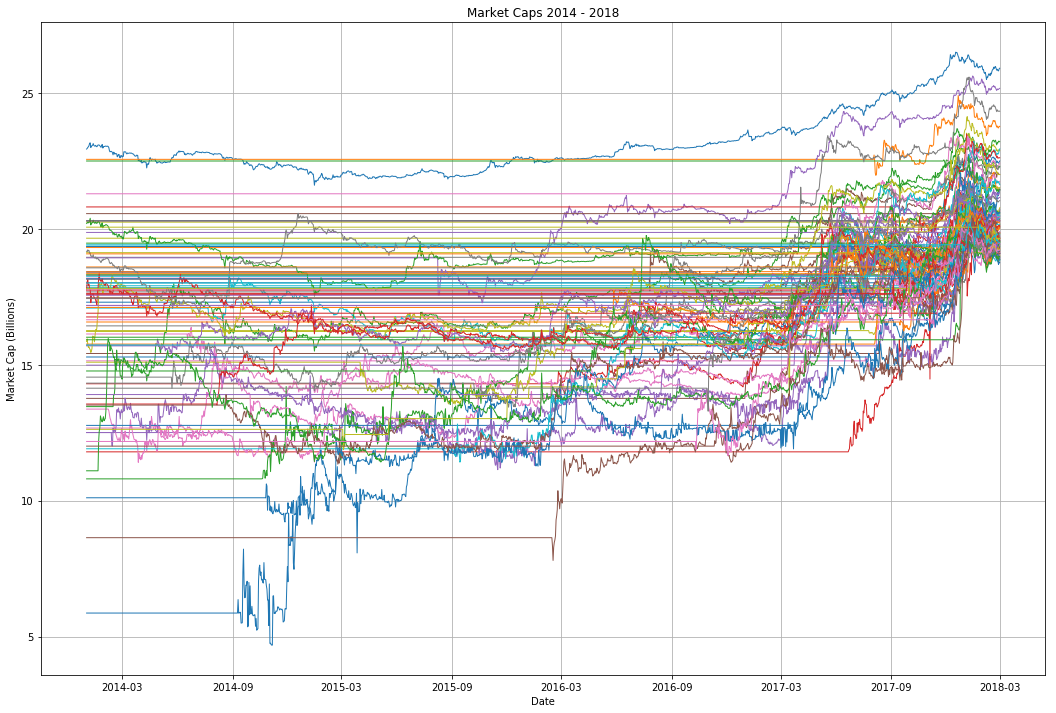

In [7]:
#x = btc_history['dt']
#y = btc_history['Market Cap'] / 1e9
plt.clf()
plt.figure(figsize=(18,12))
x = pd.to_datetime(price_tensor['Bitcoin']['Date'])
for coin in price_tensor.items:
    y = np.log(pd.to_numeric(price_tensor[coin]['Market Cap']))
    plt.plot(x, y, linewidth=1, label=coin)

plt.xlabel('Date')
#plt.xticks(np.arange(1900, 2020, 10.0))
plt.ylabel('Market Cap (Billions)')
plt.title("Market Caps 2014 - 2018")
#plt.legend(loc='upper left')
plt.grid(True)

### Convert date to two features: Day of Year, and Month

In [8]:
doy = pd.to_datetime(price_tensor['Bitcoin']['Date']).apply(lambda x: x.dayofyear)
doy_plane = np.tile(doy, 100)
doy_plane = doy_plane.reshape(100, len(doy_plane)//100)

month = pd.to_datetime(price_tensor['Bitcoin']['Date']).apply(lambda x: x.month)
month_plane = np.tile(month, 100)
month_plane = month_plane.reshape(100, len(month_plane)//100)

pt = np.dstack([price_tensor, doy_plane, month_plane])
pt = xr.DataArray(pt, dims=['coins', 'days', 'features'])

In [9]:
pt.shape

(100, 1520, 9)

In [10]:
price_tensor.isna().sum()

,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Date,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Open,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Volume,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Market Cap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Now for some Deep Learning
We will now use convulutional networks to evaluate coins and predict price movement

In [340]:
from DeepLearning.CNN import Evaluator
ev = Evaluator()
model = ev.model

AttributeError: 'Evaluator' object has no attribute 'model'

In [209]:
from datetime import timedelta, date

train_start_date = date(2015,1,1)
train_end_date   = date(2018,1,1)
test_start_date  = date(2018,1,2)
test_end_date    = date(2018,3,2)

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

for t, single_date in enumerate(daterange(train_start_date, train_end_date)):
    X = pt[:,t:t+60,:]
    y = pt[:,t+60+1,4] # 4 is the index of closing price in features
    if not t % 100:
        print("X: ", X)
        print("Shape X: ", X.shape)
        print("y: ", y.values)
    
    # normalize prices with respect to the 'current' price. ie. the final closing price before our prediction
    # price features are open, high, low, close, with indices 1, 2, 3, 4
    current_prices = X[:,t+60,4]
    X[:, :, 1] = X[:,:,1] / current_price[:,None]
    X[:, :, 2] = X[:,:,2] / current_price[:,None]
    X[:, :, 3] = X[:,:,3] / current_price[:,None]
    X[:, :, 4] = X[:,:,4] / current_price[:,None]
    y = y / current_price
    
    # drop date
    X = X[:,:,1:]
    
    # run training for example
    
    # Add sample dimension
    X_in = xr.DataArray([X])
    
    
    
    
        

X:  <xarray.DataArray (coins: 100, days: 60, features: 9)>
array([[['Feb 28, 2018', 0.992029, ..., 59, 2],
        ['Feb 27, 2018', 1.04, ..., 58, 2],
        ...,
        ['Jan 01, 2018', 0.904355, ..., 1, 1],
        ['Dec 31, 2017', 0.685294, ..., 365, 12]],

       [['Feb 28, 2018', 2.43, ..., 59, 2],
        ['Feb 27, 2018', 2.24, ..., 58, 2],
        ...,
        ['Jan 01, 2018', 1.32, ..., 1, 1],
        ['Dec 31, 2017', 1.22, ..., 365, 12]],

       ...,

       [['Feb 28, 2018', 0.051722, ..., 59, 2],
        ['Feb 27, 2018', 0.05394, ..., 58, 2],
        ...,
        ['Jan 01, 2018', 0.136822, ..., 1, 1],
        ['Dec 31, 2017', 0.136822, ..., 365, 12]],

       [['Feb 28, 2018', 1.18, ..., 59, 2],
        ['Feb 27, 2018', 1.2, ..., 58, 2],
        ...,
        ['Jan 01, 2018', 0.993784, ..., 1, 1],
        ['Dec 31, 2017', 0.8782049999999999, ..., 365, 12]]], dtype=object)
Dimensions without coordinates: coins, days, features
Shape X:  (100, 60, 9)
y:  [0.684076 1.33 4.75 1